In [ ]:
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f"Size of train dataset: {train_data.memory_usage().sum() / (1024 * 1024):.2f} MB")
print(f"Size of test dataset: {test_data.memory_usage().sum() / (1024 * 1024):.2f} MB")

print(f"Number of entries in train dataset: {train_data.shape[0]}")
print(f"Number of features in train dataset: {train_data.shape[1]}")

print(f"Number of entries in test dataset: {test_data.shape[0]}")
print(f"Number of features in test dataset: {test_data.shape[1]}")

print(train_data.isnull().sum().sort_values(ascending=False).head(10))

print(train_data.select_dtypes(include=['object']).columns)




Size of train dataset: 0.90 MB
Size of test dataset: 0.89 MB
Number of entries in train dataset: 1460
Number of features in train dataset: 81
Number of entries in test dataset: 1459
Number of features in test dataset: 80
PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageYrBlt      81
GarageCond       81
GarageType       81
dtype: int64
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDr

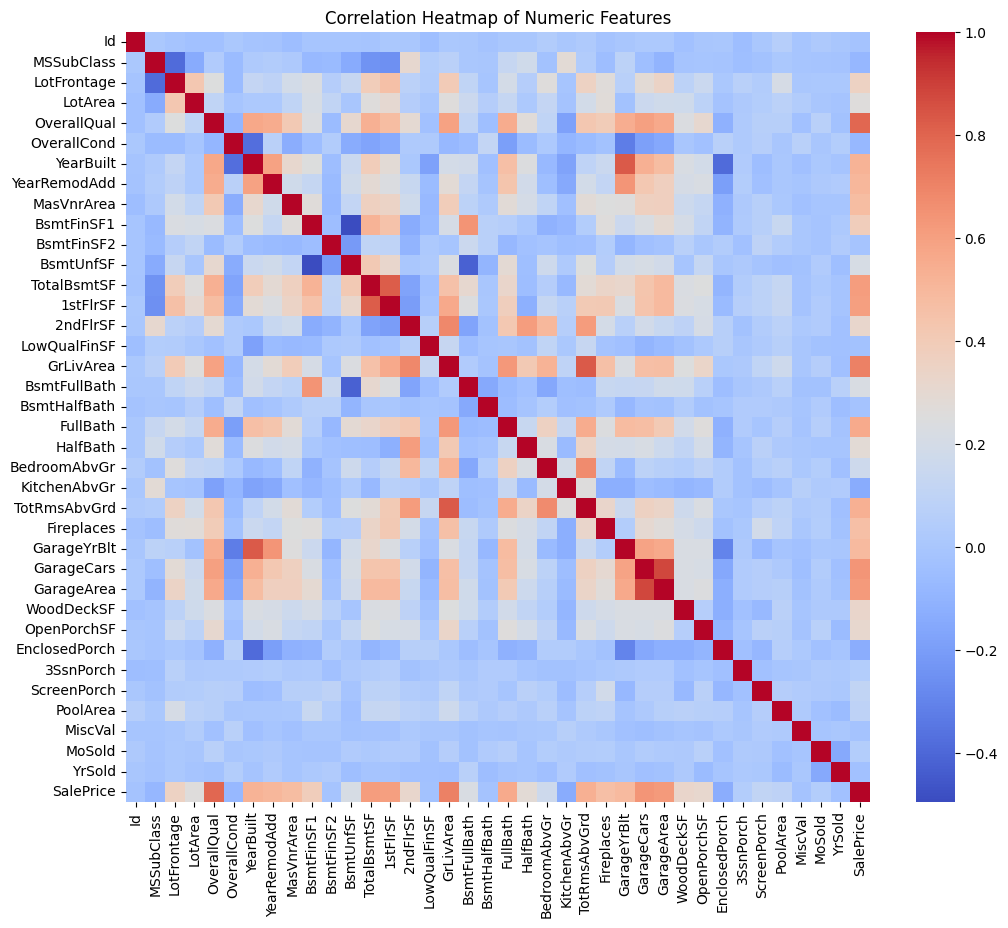

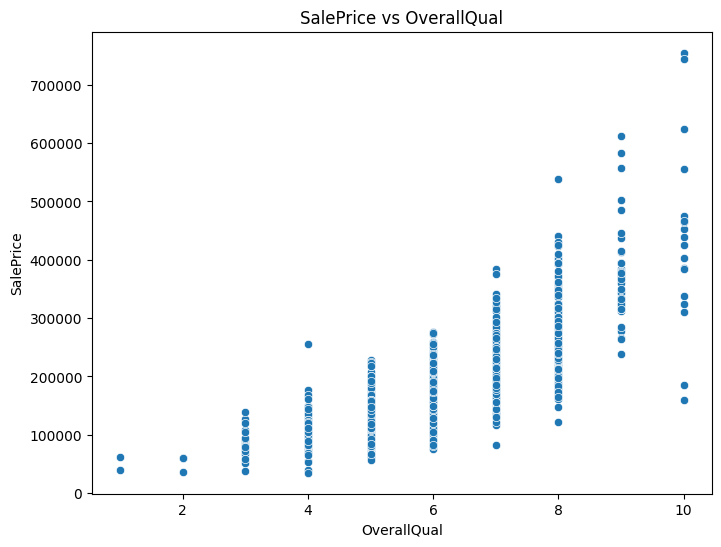

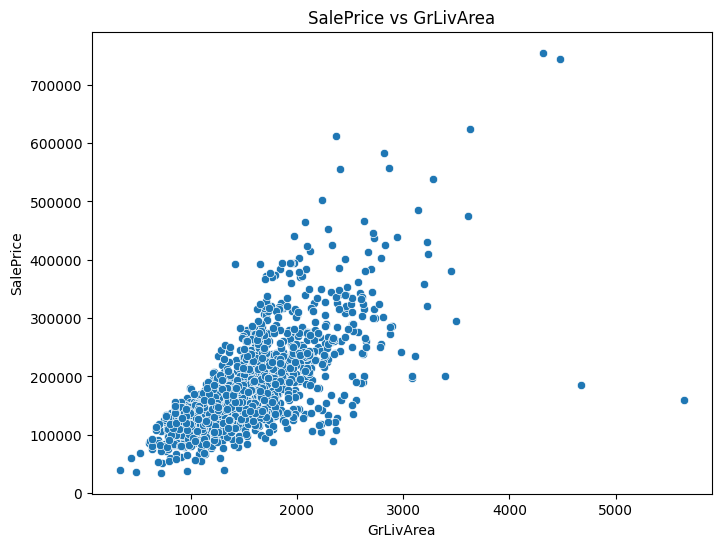

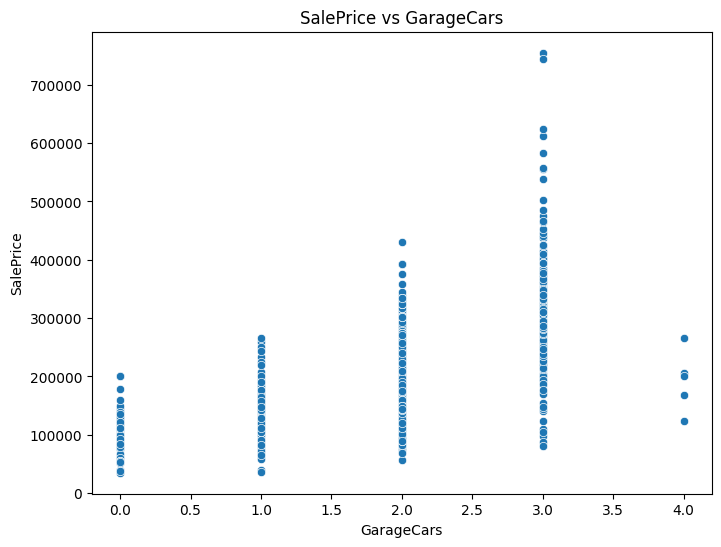

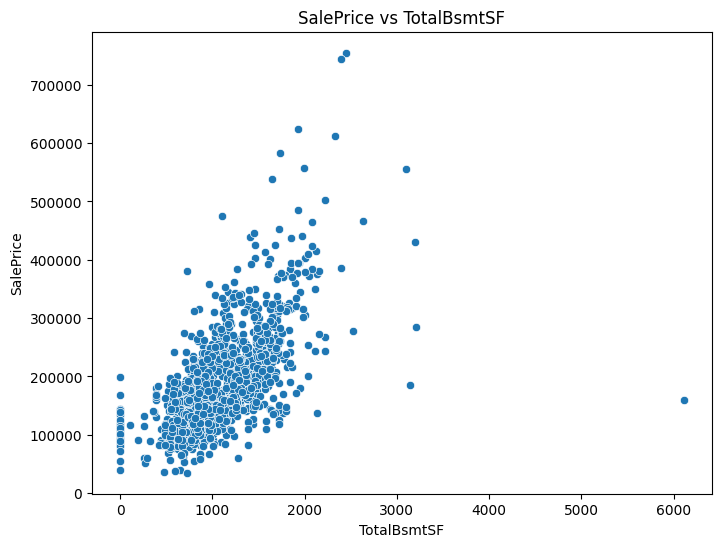

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = train_data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
correlation_matrix = numeric_features.corr()

#heatmap plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

#scatterplot
important_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']
for feature in important_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=train_data[feature], y=train_data['SalePrice'])
    plt.title(f'SalePrice vs {feature}')
    plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

if 'SalePrice' in train_data.columns:
    X = train_data.drop('SalePrice', axis=1)
    y = train_data['SalePrice']

    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    num_features = X.select_dtypes(include=['int64', 'float64']).columns
    cat_features = X.select_dtypes(include=['object']).columns

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_features),
    ])

    X_train_prepared = full_pipeline.fit_transform(X_train)
    X_valid_prepared = full_pipeline.transform(X_valid)
    X_test_prepared = full_pipeline.transform(X_test)

    print("Data preparation and splitting successful!")
else:
    print("Cannot proceed without 'SalePrice'. Please check the dataset.")


Data preparation and splitting successful!


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

results = {}
for name, model in models.items():
    # 5-fold cross-validation
    scores = cross_val_score(model, X_train_prepared, y_train, scoring='neg_root_mean_squared_error', cv=5)
    results[name] = -scores.mean()  # RMSE is the negative of the mean score returned by cross_val_score

for name, rmse in results.items():
    print(f"{name}: RMSE = {rmse:.2f}")



Linear Regression: RMSE = 38433.45
Decision Tree: RMSE = 40644.51
Random Forest: RMSE = 30657.59


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE: 30270.072447212442
Cross-Validation RMSE Scores: [30254.0829627  43955.35376354 22207.13840384 29668.79505353
 25549.38234839]
Mean RMSE: 30326.950506402627
Standard Deviation of RMSE: 7415.232426615046
Train RMSE: 12339.62


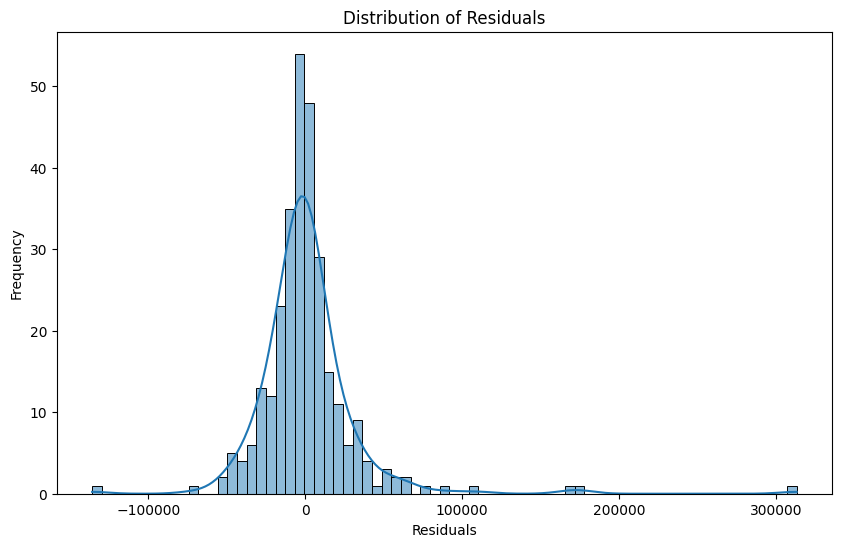

Train RMSE: 12339.62


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# fit GridSearchCV
grid_search.fit(X_train_prepared, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

best_rf = grid_search.best_estimator_

cv_scores = cross_val_score(best_rf, X_train_prepared, y_train, cv=5, scoring='neg_root_mean_squared_error')

print("Cross-Validation RMSE Scores:", -cv_scores)
print("Mean RMSE:", -cv_scores.mean())
print("Standard Deviation of RMSE:", cv_scores.std())

y_train_pred = best_rf.predict(X_train_prepared)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Train RMSE: {train_rmse:.2f}")

y_test_pred = best_rf.predict(X_test_prepared)

residuals = y_test - y_test_pred

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

y_train_pred = best_rf.predict(X_train_prepared)

from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Train RMSE: {train_rmse:.2f}")